Setup and Data Loading

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('/home/silver/Healthcare-Chatbot-using-Natural-Language-Processing/clean datasets/Symptom2Disease_cleaned.csv')

[nltk_data] Downloading package punkt to /home/silver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/silver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
import nltk

# Download all required NLTK data
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal
nltk.download('wordnet')  # For lemmatization (alternative to stemming)
nltk.download('omw-1.4')  # Open Multilingual WordNet (required for wordnet)

# Verify NLTK data path
print("NLTK data paths:", nltk.data.path)

[nltk_data] Downloading package punkt to /home/silver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/silver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/silver/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/silver/nltk_data...


NLTK data paths: ['/home/silver/nltk_data', '/home/silver/Healthcare-Chatbot-using-Natural-Language-Processing/venv/nltk_data', '/home/silver/Healthcare-Chatbot-using-Natural-Language-Processing/venv/share/nltk_data', '/home/silver/Healthcare-Chatbot-using-Natural-Language-Processing/venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


Text Preprocessing

In [12]:
import pandas as pd
import string
from nltk.tokenize import RegexpTokenizer  # Fallback tokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')  # Fallback tokenizer

def robust_preprocess(text):
    try:
        if not isinstance(text, str) or not text.strip():
            return ""
            
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Try NLTK word_tokenize first, fallback to regex tokenizer if it fails
        try:
            tokens = word_tokenize(text)
        except:
            tokens = tokenizer.tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        return ' '.join(tokens)
        
    except Exception as e:
        print(f"Error processing text: {text[:50]}... Error: {str(e)[:100]}...")
        return ""

# Apply preprocessing
df['processed_text'] = df['text'].apply(robust_preprocess)

# Verify results
print("\nSample preprocessing results:")
for i in range(3):
    print(f"\nOriginal {i+1}: {df['text'].iloc[i]}")
    print(f"Processed {i+1}: {df['processed_text'].iloc[i]}")


Sample preprocessing results:

Original 1: i have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. it is red, itchy, and covered in dry, scaly patches.
Processed 1: experiencing skin rash arm leg torso past week red itchy covered dry scaly patch

Original 2: my skin has been peeling, especially on my knees, elbows, and scalp. this peeling is often accompanied by a burning or stinging sensation.
Processed 2: skin peeling especially knee elbow scalp peeling often accompanied burning stinging sensation

Original 3: i have been experiencing joint pain in my fingers, wrists, and knees. the pain is often achy and throbbing, and it gets worse when i move my joints.
Processed 3: experiencing joint pain finger wrist knee pain often achy throbbing get worse move joint


In [13]:
import re
from nltk.corpus import wordnet

# Enhanced medical preprocessing
def medical_preprocess(text):
    try:
        if not isinstance(text, str) or not text.strip():
            return ""
            
        # Convert to lowercase
        text = text.lower()
        
        # Handle medical abbreviations/contractions
        text = re.sub(r"\b(i've|i'm|i'd)\b", "", text)
        
        # Special handling for numeric symptoms
        text = re.sub(r"(\d+)\s*(hours|days|weeks|months|years)", r"\1_\2", text)
        
        # Remove punctuation but keep hyphens in compound terms
        text = re.sub(r"(?<!\w)[.,;:!?](?!\w)", "", text)
        
        # Tokenize with fallback
        try:
            tokens = word_tokenize(text)
        except:
            tokens = tokenizer.tokenize(text)
        
        # Medical stopwords to keep
        medical_keep = {'no', 'not', 'nor', 'very', 'more', 'most', 'less', 'least'}
        stop_words = set(stopwords.words('english')) - medical_keep
        
        # Lemmatize with POS tagging for better accuracy
        def lemmatize_with_pos(word):
            pos = wordnet.ADJ if word.endswith(('ing', 'ed')) else wordnet.NOUN
            return lemmatizer.lemmatize(word, pos=pos)
        
        tokens = [lemmatize_with_pos(word) for word in tokens 
                 if word not in stop_words and len(word) > 2]
        
        return ' '.join(tokens)
        
    except Exception as e:
        print(f"Error processing: {text[:50]}... Error: {str(e)[:100]}...")
        return ""

# Apply enhanced preprocessing
df['med_processed'] = df['text'].apply(medical_preprocess)

# Show comparison
print("\nEnhanced Medical Preprocessing Results:")
for i in range(3):
    print(f"\nOriginal {i+1}: {df['text'].iloc[i]}")
    print(f"Standard: {df['processed_text'].iloc[i]}")
    print(f"Medical: {df['med_processed'].iloc[i]}")


Enhanced Medical Preprocessing Results:

Original 1: i have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. it is red, itchy, and covered in dry, scaly patches.
Standard: experiencing skin rash arm leg torso past week red itchy covered dry scaly patch
Medical: experiencing skin rash arm leg torso past week red itchy covered dry scaly patch

Original 2: my skin has been peeling, especially on my knees, elbows, and scalp. this peeling is often accompanied by a burning or stinging sensation.
Standard: skin peeling especially knee elbow scalp peeling often accompanied burning stinging sensation
Medical: skin peeling especially knee elbow scalp peeling often accompanied burning stinging sensation

Original 3: i have been experiencing joint pain in my fingers, wrists, and knees. the pain is often achy and throbbing, and it gets worse when i move my joints.
Standard: experiencing joint pain finger wrist knee pain often achy throbbing get worse move joint
Med

Feature Extraction with N-gram TF-IDF

In [16]:
# Initialize TF-IDF Vectorizer with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Using both unigrams and bigrams
    max_features=5000,    # Limiting to top 5000 features
    dtype=np.float32      # Explicit data type for better memory management
)

# Fit and transform the processed text
tfidf_features = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert to dense array only if needed (sparse is more memory efficient)
try:
    # Safe conversion with type checking
    if hasattr(tfidf_features, 'toarray'):
        tfidf_array = tfidf_features.toarray()
    else:
        tfidf_array = tfidf_features  # Keep as sparse matrix if toarray() not available
    
    # Create DataFrame
    tfidf_df = pd.DataFrame(
        data=tfidf_array,
        columns=tfidf_vectorizer.get_feature_names_out(),
        dtype=np.float32
    )
    
    print("\nTF-IDF features shape:", tfidf_features.shape)
    print("\nSample feature names:", tfidf_vectorizer.get_feature_names_out()[:20])
    
except Exception as e:
    print(f"Error during TF-IDF conversion: {str(e)}")
    # Fallback to sparse representation
    print("\nTF-IDF features shape (sparse):", tfidf_features.shape)
    print("Sample feature names:", tfidf_vectorizer.get_feature_names_out()[:20])


TF-IDF features shape: (1153, 5000)

Sample feature names: ['abdomen' 'abdomen ache' 'abdomen bothering' 'abdomen discomfort'
 'abdomen felt' 'abdomen frequently' 'abdomen get' 'abdomen hour'
 'abdomen hurt' 'abdomen itchy' 'abdomen last' 'abdomen ofetn'
 'abdomen often' 'abdomen really' 'abdomen throughout' 'abdominal'
 'abdominal ache' 'abdominal cramp' 'abdominal pain' 'abdominal part']



Disease: Psoriasis
Top features: ['joint extreme', 'skin starting', 'infection joint', 'flaky area', 'skin prone']

Disease: Varicose Veins
Top features: ['also overweight', 'reason', 'reason behind', 'protruding', 'overweight']

Disease: Typhoid
Top features: ['ive diarrhoea', 'time day', 'loose watery', 'watery stool', 'lot dont']

Disease: Chicken pox
Top features: ['headache always', 'body itch', 'red swollen', 'always feel', 'itch touch']

Disease: Impetigo
Top features: ['helping much', 'helping', 'healing tried', 'difficult handle', 'face healing']


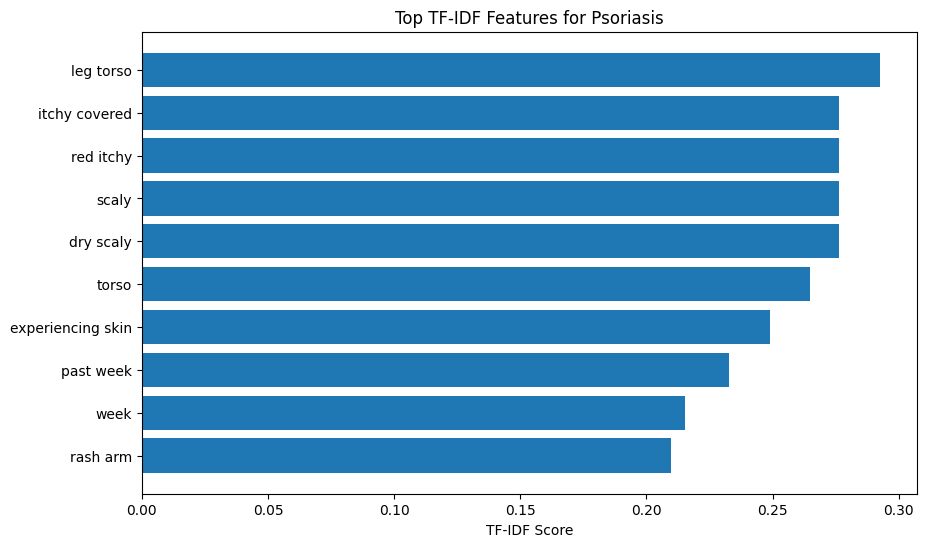

In [17]:
# Get top N important features per disease
def get_top_n_features(tfidf_matrix, feature_names, labels, top_n=5):
    top_features = {}
    for i, label in enumerate(labels):
        row = np.squeeze(tfidf_matrix[i].toarray())
        top_indices = row.argsort()[-top_n:][::-1]
        top_features[label] = [feature_names[j] for j in top_indices]
    return top_features

top_features = get_top_n_features(tfidf_features, 
                                 tfidf_vectorizer.get_feature_names_out(), 
                                 df['label'])

# Print top features for first 5 diseases
for disease, features in list(top_features.items())[:5]:
    print(f"\nDisease: {disease}")
    print("Top features:", features)

# Visualize feature importance for a sample disease
sample_disease = df['label'].iloc[0]
sample_idx = df[df['label'] == sample_disease].index[0]
sample_features = tfidf_features[sample_idx]

# Get top 10 features for this sample
top_indices = sample_features.toarray().argsort()[0][-10:][::-1]
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_feature_names = feature_names[top_indices]
top_feature_values = sample_features[0, top_indices].toarray()[0]

plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_values)
plt.title(f"Top TF-IDF Features for {sample_disease}")
plt.xlabel("TF-IDF Score")
plt.gca().invert_yaxis()
plt.show()